# Языковые модели


## Нейронные сети-трансформеры

Трансформеры - это новый класс нейронных сетей, основанных на механизме **self-attention**. Схема ячейки-трансформера, описанной в статье 2017 года "Attention is all you need", представлена на изображении ниже:

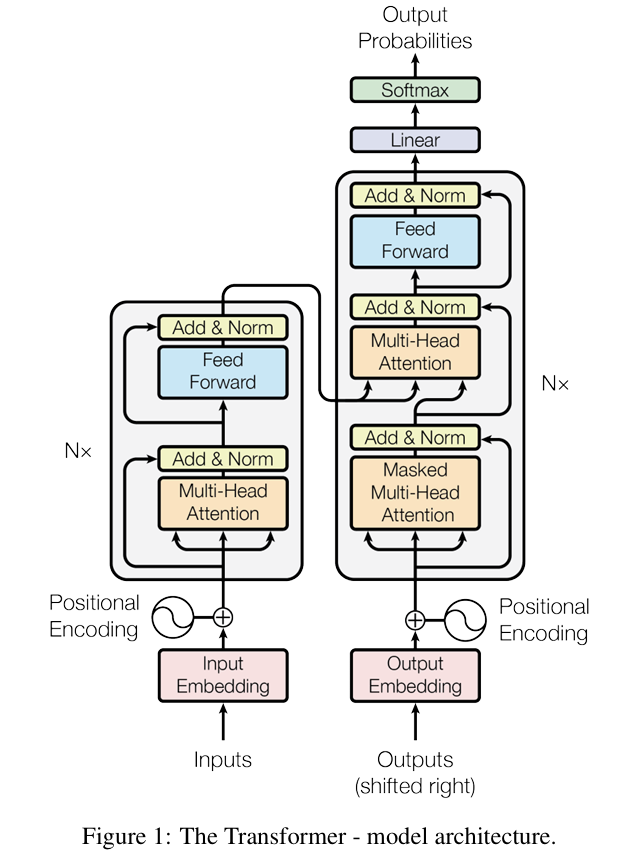

Основной блок этой ячейки - Multi-Head Attention основан на механизме self-attention.  Self-attention - это механизм преобразования эмбеддинга конкретного слова на основании его контекста с учетом влияния слов друг на друга в рамках этого контекста. Слова в языке связаны друг с другом, механизм self-attention предлагает учитывать "вес" связи каждого слова с каждым при помощи создания для каждого слова трёх категорий векторов: value ($v$), query ($q$) и key ($k$). Чтобы определить "вес" влияния слова $w_i$ на слово $w_j$ в определенном контексте, строится функция:
$$f(\vec{v}_i, \vec{k}_i, \vec{q}_j) = ρ(\vec{k}_i, \vec{q}_j)⋅\vec{v}_i$$
Где функция $\rho$ определяет близость векторов  $\vec{k}_i$ и $\vec{q}_j$ и обычно представляет из себя обычное скалярное произведение. Тогда обновленный вектор слова $out_j$ определяется как совокупность таких "влияний" других слов на само слово $w_j$:
$$out_j = \sum\limits_{i=1}^nρ(\vec{k}_i, \vec{q}_j)⋅\vec{v}_i$$

В этом случае векторы value, query и key приобретают следующий смысл:

- Value vector - вектор, являющийся представлением эмбеддинга слова, с которым будут производиться манипуляции
- Query vector - вектор "запроса", то есть вектор, передающийся со стороны *оцениваемого* слова для определения влияния на него другого слова из контекста
- Key vector - вектор "ключ", нужный для определения данного слова на другое слово в контексте

Все три вектора формируются при помощи трёх параметризованных матриц: $Q$, $V$ и $K$. Получая на вход эмбеддинг слова, три необходимых для self-attention вектора формируются произведением этих матриц на исходный эмбеддинг $w_i$:
$$\vec{v}_i = V\vec{w}_i$$
$$\vec{q}_i = V\vec{Q}_i$$
$$\vec{k}_i = V\vec{K}_i$$

Именно эти матрицы и являются обучаемыми параметрами системы. Механизм *multi-head attention* состоит в параллельном вычислении нескольких вариантов такого преобразования на каждом слое.

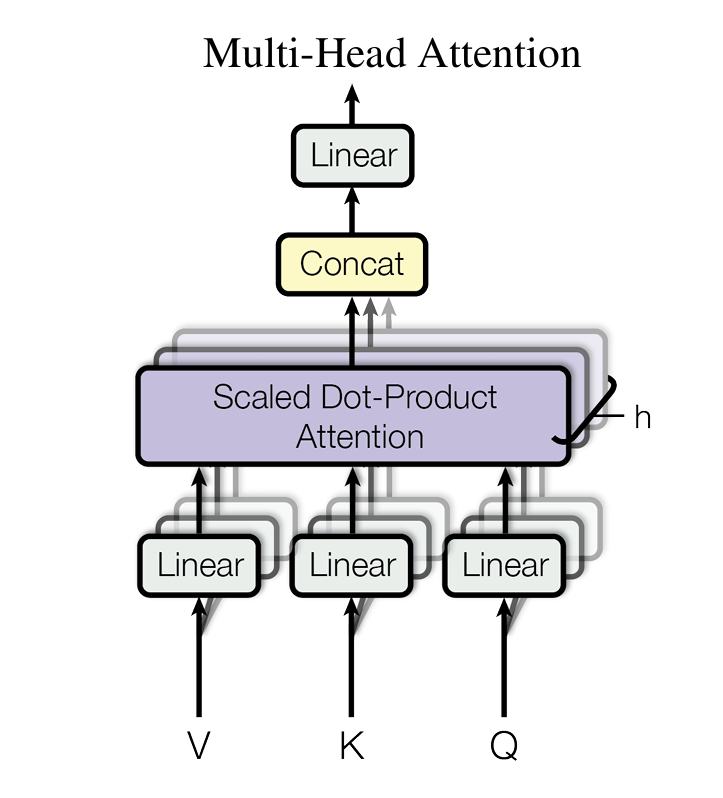

## Языковое моделирование

**Языковыми моделями** обычно называют любые системы, способные *прогнозировать* пропущенные или последующие слова по контексту. Обычно при работе с языковыми моделями пользуются некоторой простой терминологией. Считается, что нам известен **словарь**, то есть множество всех возможных слов, которые мы можем встретить в данном языке. Эти слова обычно называются *токенами*, а процесс разбиения тексты на токены - **токенизацией**. В настоящих языковых моделях токен обычно не представляет слово в буквальном смысле, на каждое слово обычно приходится несколько токенов, так что токены можно условно рассматривать как специфическую форму морфем. Пока что мы не будем углубляться в подробности процесса токенизации, хотя на этой лекции еще поговорим о ней подробнее, пока что можно воспринимать токены как некоторые фиксированные части слов или даже как целые слова.

**Языковой моделью** в этом случае мы будем называть модель *условного вероятностного распределения* по всему словарю, где обуславливание происходит на некоторый контекст. Подробно этот механизм был описан в лекции по RNN.

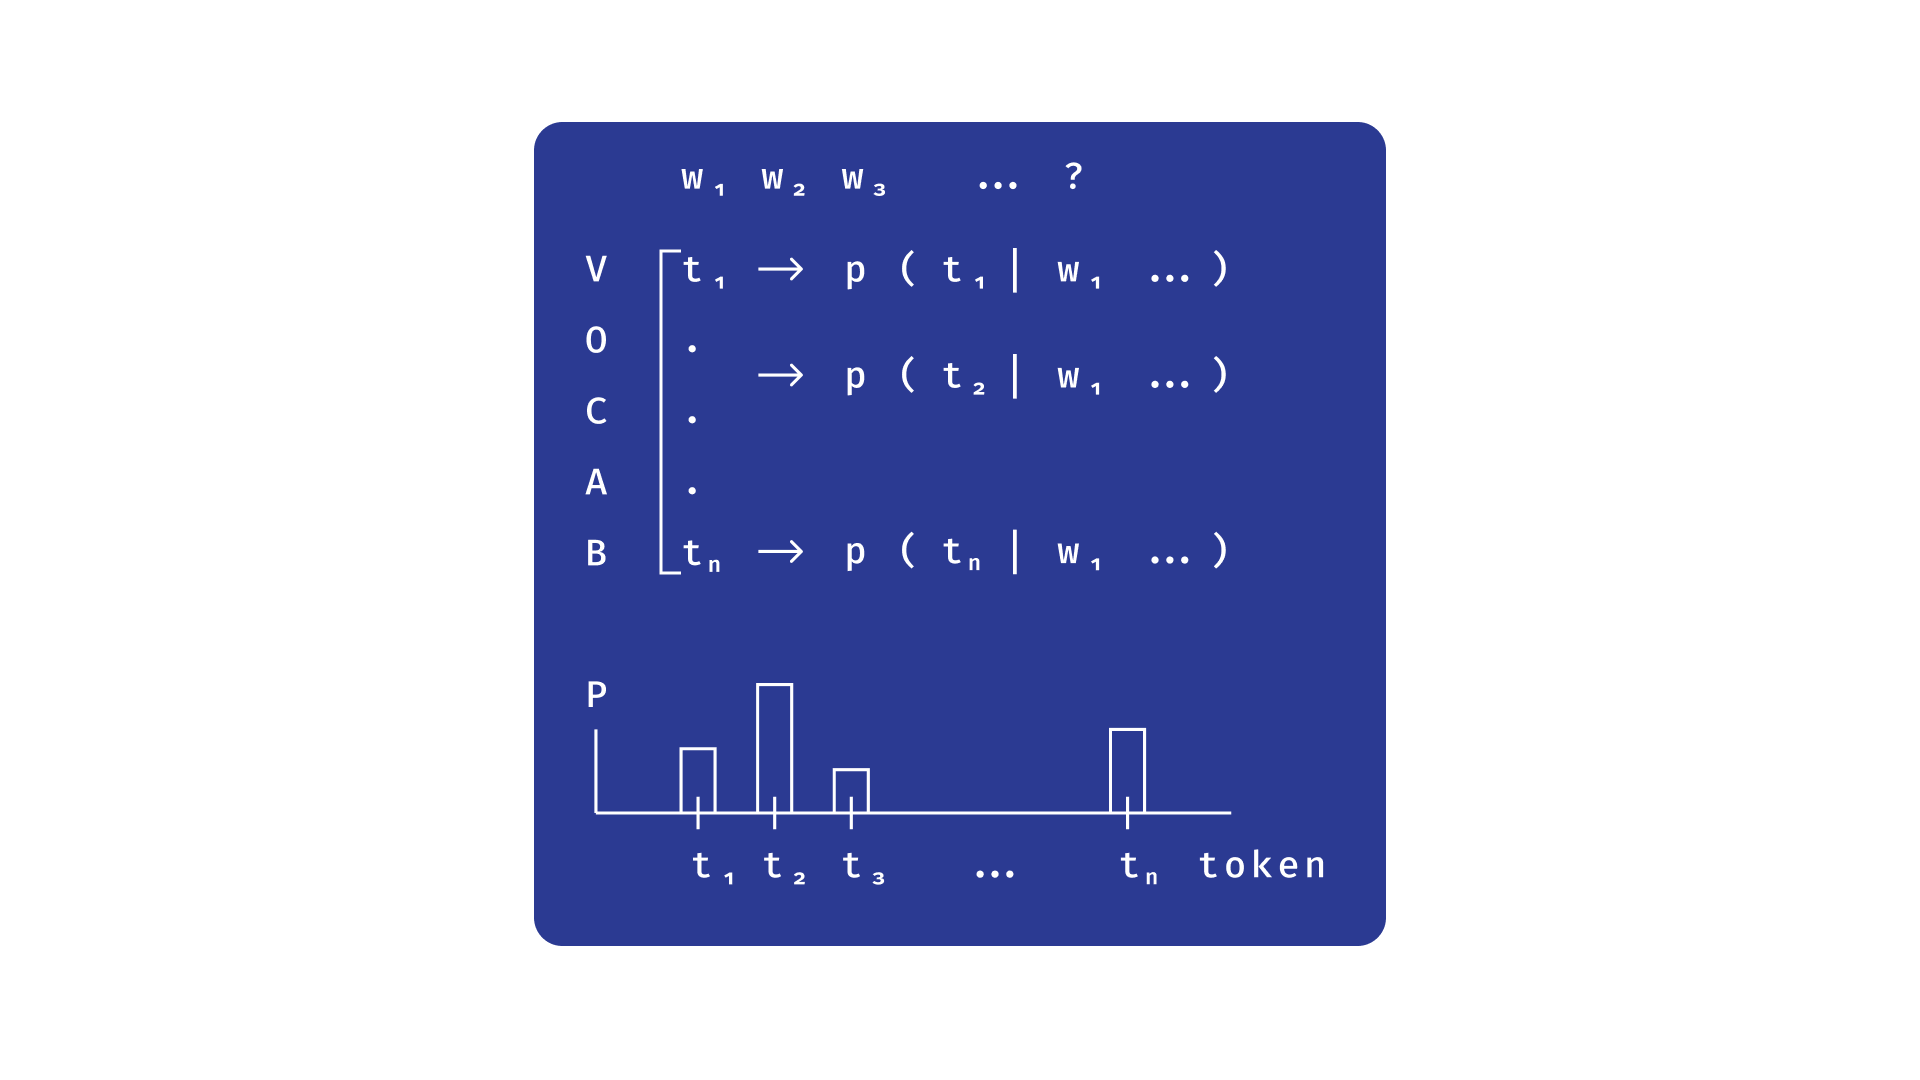

Иначе говоря, языковая модель - это инструмент, способный прогнозировать слова по их контексту. В наилучшем случае, если качество прогнозирования достаточно высоко, такие модели могут дописывать или писать тексты целиком, опираясь на свои прогнозы предыдущих слов, как на слова контекста. На этой лекции мы разберемся с тем, как работают некоторые из популярных языковых моделей и почему на основе языковых моделей можно строить *универсальные* методы решения широкого спектра задач обработки естественного языка.

В предыдущих лекциях вы уже сталкивались с задачей языкового моделирования в контексте обсуждения рекуррентных нейронных сетей. Можно разделить языковое моделирование на следующие категории:

- Прямое языковое моделирование (прогнозирование следующего слова по предыдущему контексту)
- Обратное языковое моделирование (прогнозирование предыдущего слова в тексте по последующему контексту)
- Маскированное языковое моделирование (прогнозирование пропущенного слова)

### Перплексия

На самом деле вопрос о том, как конкретно будет устроена модель $P(t_i|context)$, не самый важный в обучении языковых моделей. Предположим, что мы уже нашли решение всех технических сложностей: взяли какую-то хорошую модель, способную эффективно выучить искомое вероятностное распределение,  собрали огромный набор данных для обучения, получили хорошие видеокарты и нашли способ эффективно распараллелить вычисления. Нам не хватает еще одного важного компонента для начала обучения - минимизируемой лосс-функции. Каким образом мы можем свести задачу обучения языковой модели к задаче минимизации некоторой функции?

Оказывается, существует стандартная функция, повсеместно используемая для обучения языковых моделей: **перплексия**. Перплексия - это мера *удивленности* модели тому, что в определенном контексте встретилось некоторое конкретное слово. Перплексия определяется следующей формулой:

$$ P(W) = ln({\prod_{i=1}^{N} p(w_i)}) = ∑\limits_{i=1}^nln(P(w_i)) $$

Где $W$ - это некоторая конкретная последовательность токенов $w_1 ... w_n$. Второе равенство в этом выражении очень важно, поскольку представляет из себя единственный способ посчитать перплексию на практике, ведь в словаре обычно содержатся сотни тысяч, миллионы и даже десятки миллионов токенов, поэтому было бы невозможно посчитать произведение вероятностей напрямую - число получилось бы очень маленьким.

Интуицию перплексии можно передать следующим образом: представим, что текст в целом - это структура, представляющая из себя набор позиций для размещения в них конкретных слов. Конкретный текст - это конкретное заполнение этих позиций словами. Какова вероятность в этом случае встретить конкретный текст? Это вероятность встретить первое слово $w_1$, и второе слово $w_2$, и третье слово $w_3$ и т.д. То есть $p(w_1)\cdot p(w_2) ⋅ p(w_3) ⋅ ...$ Однако, напрямую посчитать такое произведение вероятностей и выполнять с ним какие-либо операции очень сложно, поскольку это число будет очень маленьким. Поэтому применяется т.н. **log-trick** - логарифмирование произведения вероятностей и переход к сумме логарифмов вместо логарифма произведения
$$ln({\prod_{i=1}^{N} p(w_i)}) = ∑\limits_{i=1}^nln(P(w_i))$$

## Self-supervised learning

Задача языкового моделирования относится к семейству задач **self-supervised learning**. Дело в том, что формально эту задачу следует отнести, с одной стороны, к области supervised learning, ведь модель учится прогнозировать определенные метки, но с другой стороны, данным не требуется предварительная разметка -  вся необходимая информация уже содержится в текстах. Такие задачи называются *self-supervised learning*. И это очень хорошо, ведь **не требуется размечать огромные наборы данных** для обучения больших моделей.

## BERT

Одной из первых и самых известных языковых моделей в мире считается **BERT** (*Bidirectional Encoder Representations from Transformers*)

Компания google в 2017 году выпустила свой продукт, собранный из набора энкодеров от обученного на большом корпусе текстов из англоязычного интернета.

Статья, в которой была предложена эта архитектура, на сегодняшний день имеет более 1000 цитирований. Если вы хотите подробнее познакомиться с архитектурой **BERT**, Вы можете также прочитать её по [ссылке](https://arxiv.org/abs/1810.04805).

Задача **BERT** состоит в формировании универсальных эмбеддингов, хорошо подходящих для решения практически любой задачи NLP. Для решения такой амбициозной задачи, создатели **BERT** исходили из следующего предположения:

------------------
Эмбеддинги, на основании которых можно эффективно прогнозировать пропущенные слова в контексте, достаточно точно моделируют семантическую структуру языка

------------------
Этот факт может показаться странным: задача прогнозирования пропущенных слов по контексту кажется очень странной сама по себе. Тем не менее, на этом (или похожих) подходе основаны все современные LLM.

Вот что об этом сказал канадский и американский ученый советского происхождения, один из сооснователей OpenAI **Илья Суцкевер**:



> Я попытаюсь объяснить, почему предсказание следующих слов требует глубокого понимания. Допустим, вы читаете детектив: сложная линия повествования, запутанные детали, разные герои, загадки, события. Представим последнюю страницу книги, на которой автор говорит: «преступление совершил…». Попробуйте предсказать это слово

В связи с этим, глобально работа с **BERT** делится на два этапа: Pre-Training и Fine-Tuning



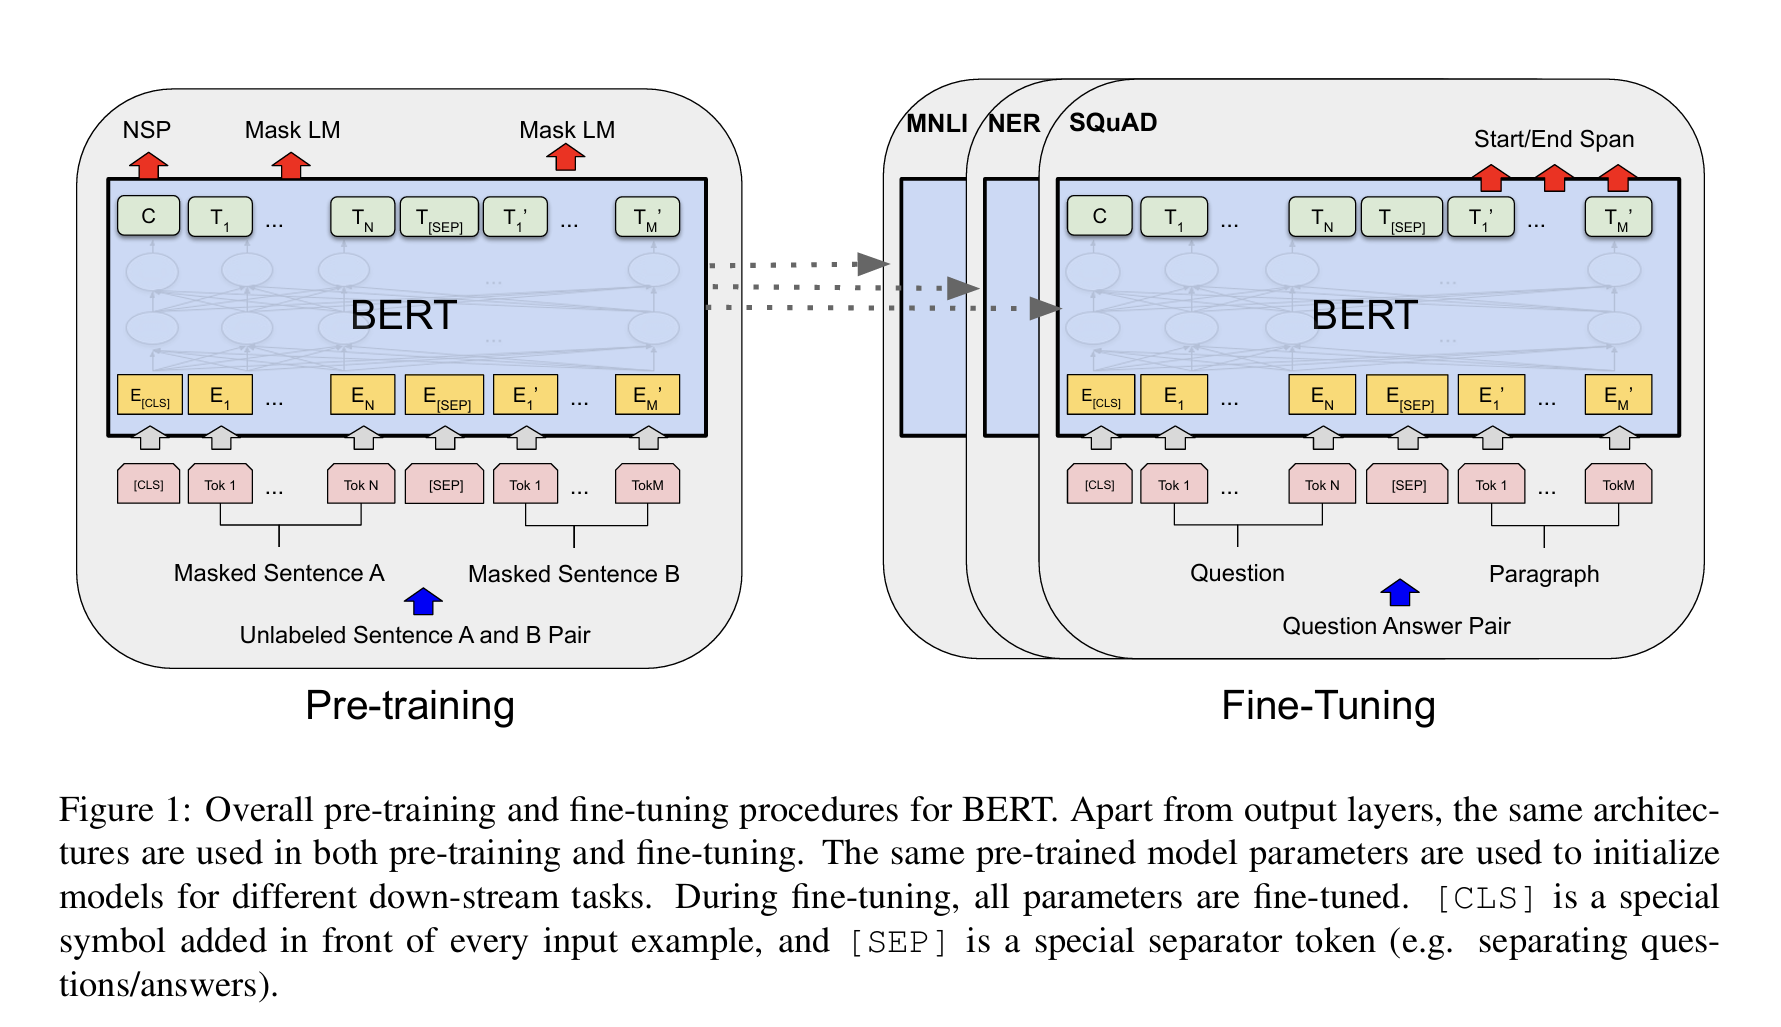

### Pre-Training

Этот этап характеризуется тем, что модель обучается формировать такие эмбеддинги, на основании которых можно эффективно прогнозировать пропущенные слова.

Эти эмбеддинги обладают свойством **контекстуальности**. Это значит, что эмбеддинг одного и того же слова будет иметь разные векторные представления в разных контекстах. Получается это следующим образом: существуют статические эмбеддинги, которые используются как входные векторные представления в self-attention. Затем, эти эмбединги проходят forward propagation через $N$ слоев энкодеров трансформеров (в оригинальном BERT есть две версии: одна с $N=12$ и вторая с $N=24$, первая версия содержит 110 млн. параметров, а вторая 340 млн. параметров)

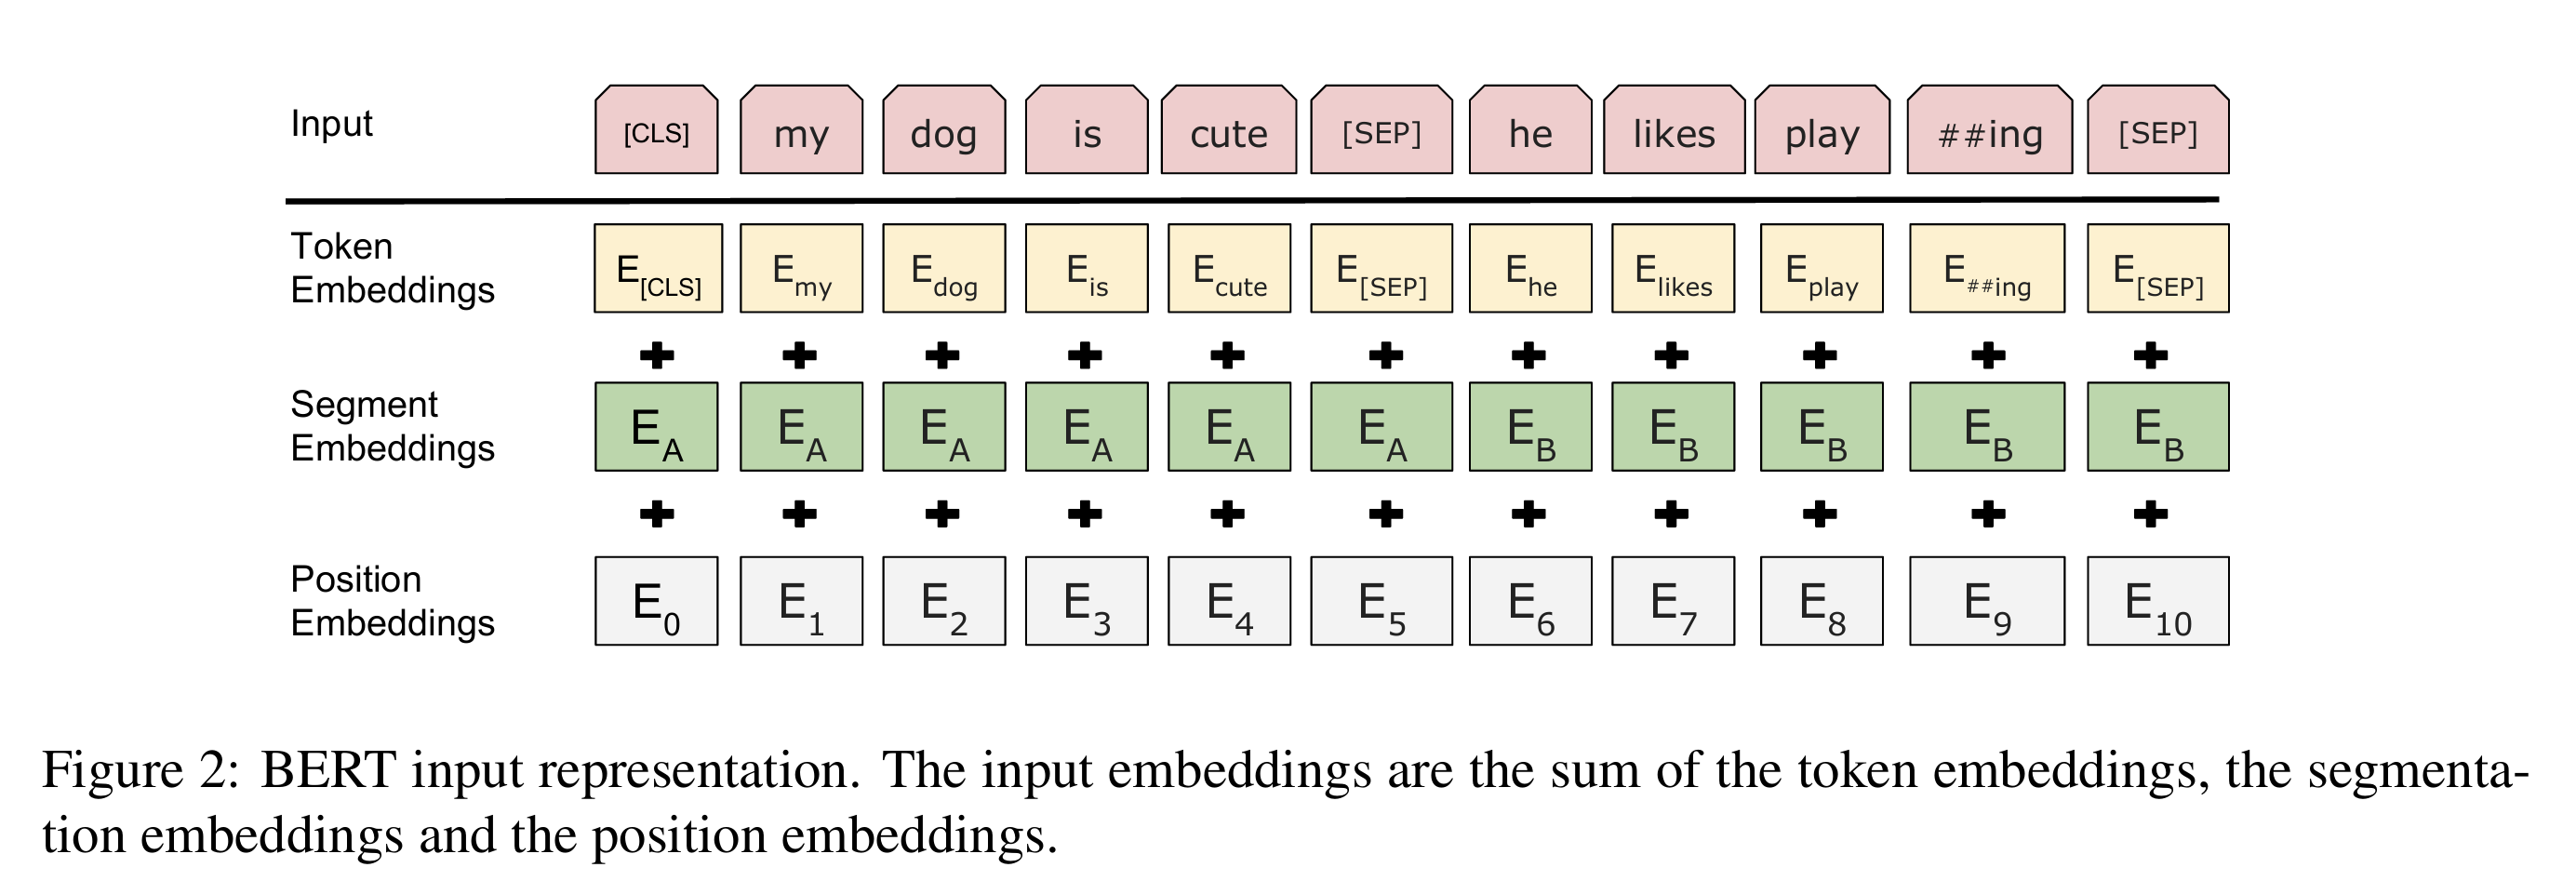

Таким образом, используя перплексию в качестве функции потерь, модель обучает для каждого слоя query, key и values матрицы по стандартной схеме работы трансформера.

### Fine-Tune

Главная особенность **BERT** состоит в том, что эмбеддинги, полученные из него, можно использовать для решения практически любой задачи. Первый вариант - это дообучение новой модели решения целевой задачи "сверху", то есть использование выходов берта как входов новой модели, которая учится отдельно. Этот вариант хорош своей сравнительной простотой, однако плох тем, что в ряде случаев требует больше вычислительных ресурсов и времени, а качество решаемой задачи тем не менее хуже, чем при использовании второго варианта.

Второй вариант нам хорошо знаком - fine-tuning, который мы встречали при обсуждении Transfer Learning, встречается и здесь. Матрицы $Q$, $V$ и $K$ для каждого слоя можно дообучать для решения конкретных задач.

Вот короткий список такого рода задач:

1. NER (Named Entity Recognition) - распознавание именованных сущностей. Технически задача сводится к тегированию токенов на предмет их принадлежности к одной из заданных категорий именованных сущностей в тексте

2. Q&A (Questions Answering) - задача выделения и суммаризации ответа на заданный по некоторому тексту вопрос

3. RTE (Recognizing Textual Entailment) - определение, являются ли два выссказывания причиной-следствием, противоречием или же нейтральными по отношению друг к другу

4. Определение тональности текста - определение позитивности, негативности или нейтральности того или иного выссказывания



### Токенизация

Для каждой модели обычно обучается специфический токенизатор. Существуют некоторые общие особенности токенизации, которые можно отнести ко всем bert-подобным моделям. Например, использование специальных токенов \<SEP> и \<CLS>. Токен \<SEP> нужен для определение окончания предложения или другого законченного фрагмента текста. Токен \<CLS> является отметкой окончания обрабатываемого фрамгента, рассматриваемого системой как единый текст, по которому нужно считать self-attention.

## Huggingface

  Общая философия работы с huggingface - это загрузка моделей через стандартизированный интерфейс, реализованный в фреймворке transformers. На google colab он не предустановлен, это необходимо сделать через pip.

  Загрузим bert-подобную модель, которой воспользуемся для генерации пропущенных фрагментов текста. Эта модель называется `bart-large`.

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Начало предложен


In [ ]:
text = "Hello, my name is <mask>"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Hello, my name is Alex.


Мы можем генерировать несколько токенов.

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)
tok = BartTokenizer.from_pretrained("facebook/bart-large")
example_english_phrase = "I Believe In <mask> Under My Bed"
batch = tok(example_english_phrase, return_tensors="pt")
generated_ids = model.generate(batch["input_ids"])

In [ ]:
tok.batch_decode(generated_ids, skip_special_tokens=True)

['I Believe In The Monster Under My Bed']

Или так:


In [ ]:
example_english_phrase = "Hello, My Name Is <mask> Color Is Green"
batch = tok(example_english_phrase, return_tensors="pt")
generated_ids = model.generate(batch["input_ids"])

In [ ]:
tok.batch_decode(generated_ids, skip_special_tokens=True)

['Hello, My Name Is Lucy and My Color Is Green']

Однако, такая модель плохо справляется с дописыванием текста

In [ ]:
example_english_phrase = "I Believe In <mask>"
batch = tok(example_english_phrase, return_tensors="pt")
generated_ids = model.generate(batch["input_ids"])

In [ ]:
tok.batch_decode(generated_ids, skip_special_tokens=True)

['I Believe In You']

## Positional Encoding

Одна из проблем структуры self-attention по сравнению, например, с рекуррентными нейронными сетями состоит в том, что классический self-attention не учитывает последовательность токенов, что, конечно, очень важно для языка.

Для преодоления этой проблемы предлагается использовать специальные "маркеры" порядка слов в предложении, которые задаются так называемыми векторами **positional encoding**.

Вообще методы формирования positional encoding бывают разные, вплоть до создания обучаемых эмбеддингов. В индустрии прижился следующий (немного сложный) метод:

Пусть мы хотим закодировать порядковый номер токена $t$ в виде вектора размерности $d$. Тогда $i$-я координата такого вектора будет задана через тригонометрические функции:

$$p_i^t = sin(w_k t), i = 2k$$
$$p_i^t = cos(w_k t), i = 2k + 1$$
Где
$$w_k = \frac{1}{10000^{\frac{2k}{d}}}$$

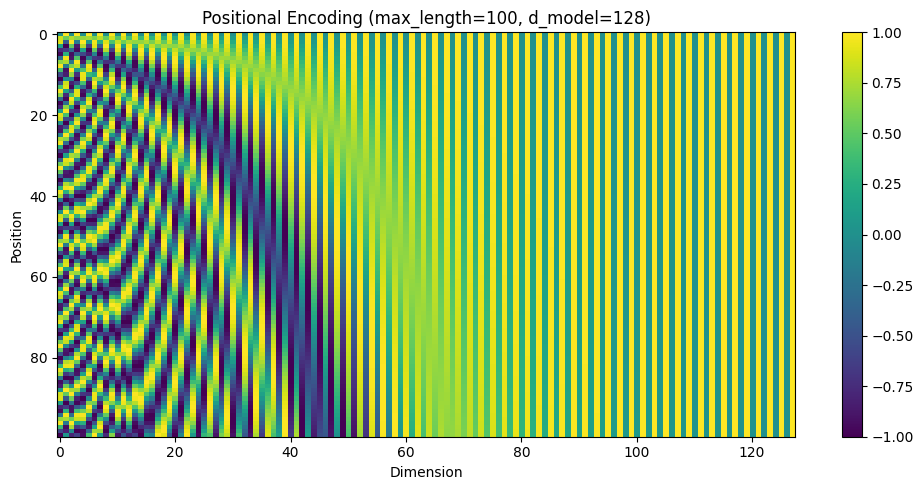

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def gen_pe(max_length, d_model, n):
    pe = torch.zeros(max_length, d_model)
    position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    return pe

def visualize_pe(max_length, d_model, n):
    pe = gen_pe(max_length, d_model, n)

    plt.figure(figsize=(10, 5))
    plt.imshow(pe.squeeze(), cmap='viridis', aspect='auto')
    plt.title(f"Positional Encoding (max_length={max_length}, d_model={d_model})")
    plt.xlabel('Dimension')
    plt.ylabel('Position')

    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Параметры для визуализации
max_length = 100
d_model = 128
n = 10000

visualize_pe(max_length, d_model, n)

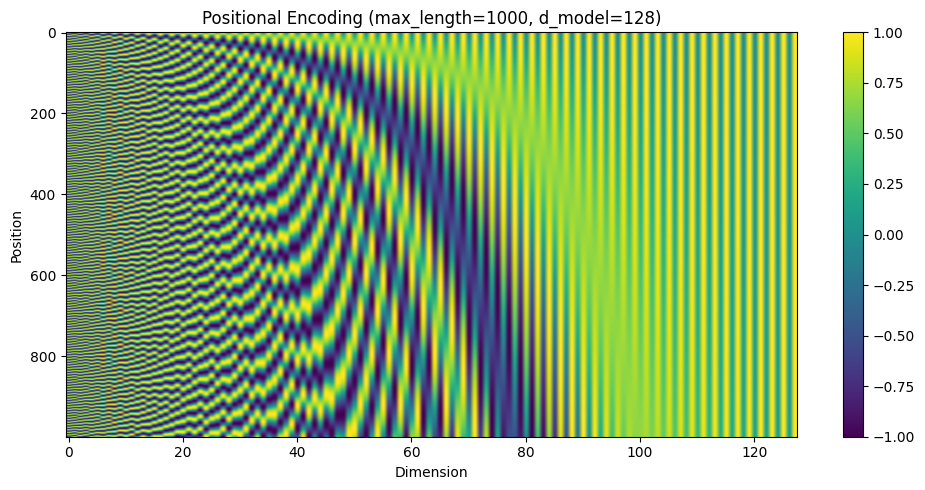

In [ ]:
# Параметры для визуализации
max_length = 1000
d_model = 128
n = 10000

visualize_pe(max_length, d_model, n)

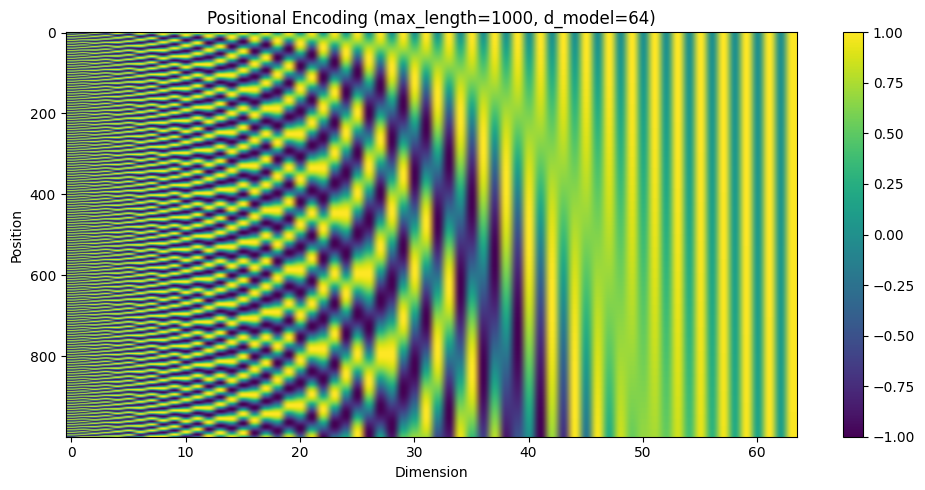

In [ ]:
# Параметры для визуализации
max_length = 1000
d_model = 64
n = 10000

visualize_pe(max_length, d_model, n)

## Мультиязычные эмбеддинги

Некоторые модели обучают сразу на нескольких языках. Такие модели называются **мультиязычными**. Существуют разные подходы к формированию мультиязычных моделей.

Рассмотрим одну из популярных мультиязычных моделей, основанных на специальной технике дообучения **BERT**, которая называется **LABSE**. Эта архитектура была представлена в статье 2022 года [Language-agnostic BERT Sentence Embedding](https://arxiv.org/pdf/2007.01852).

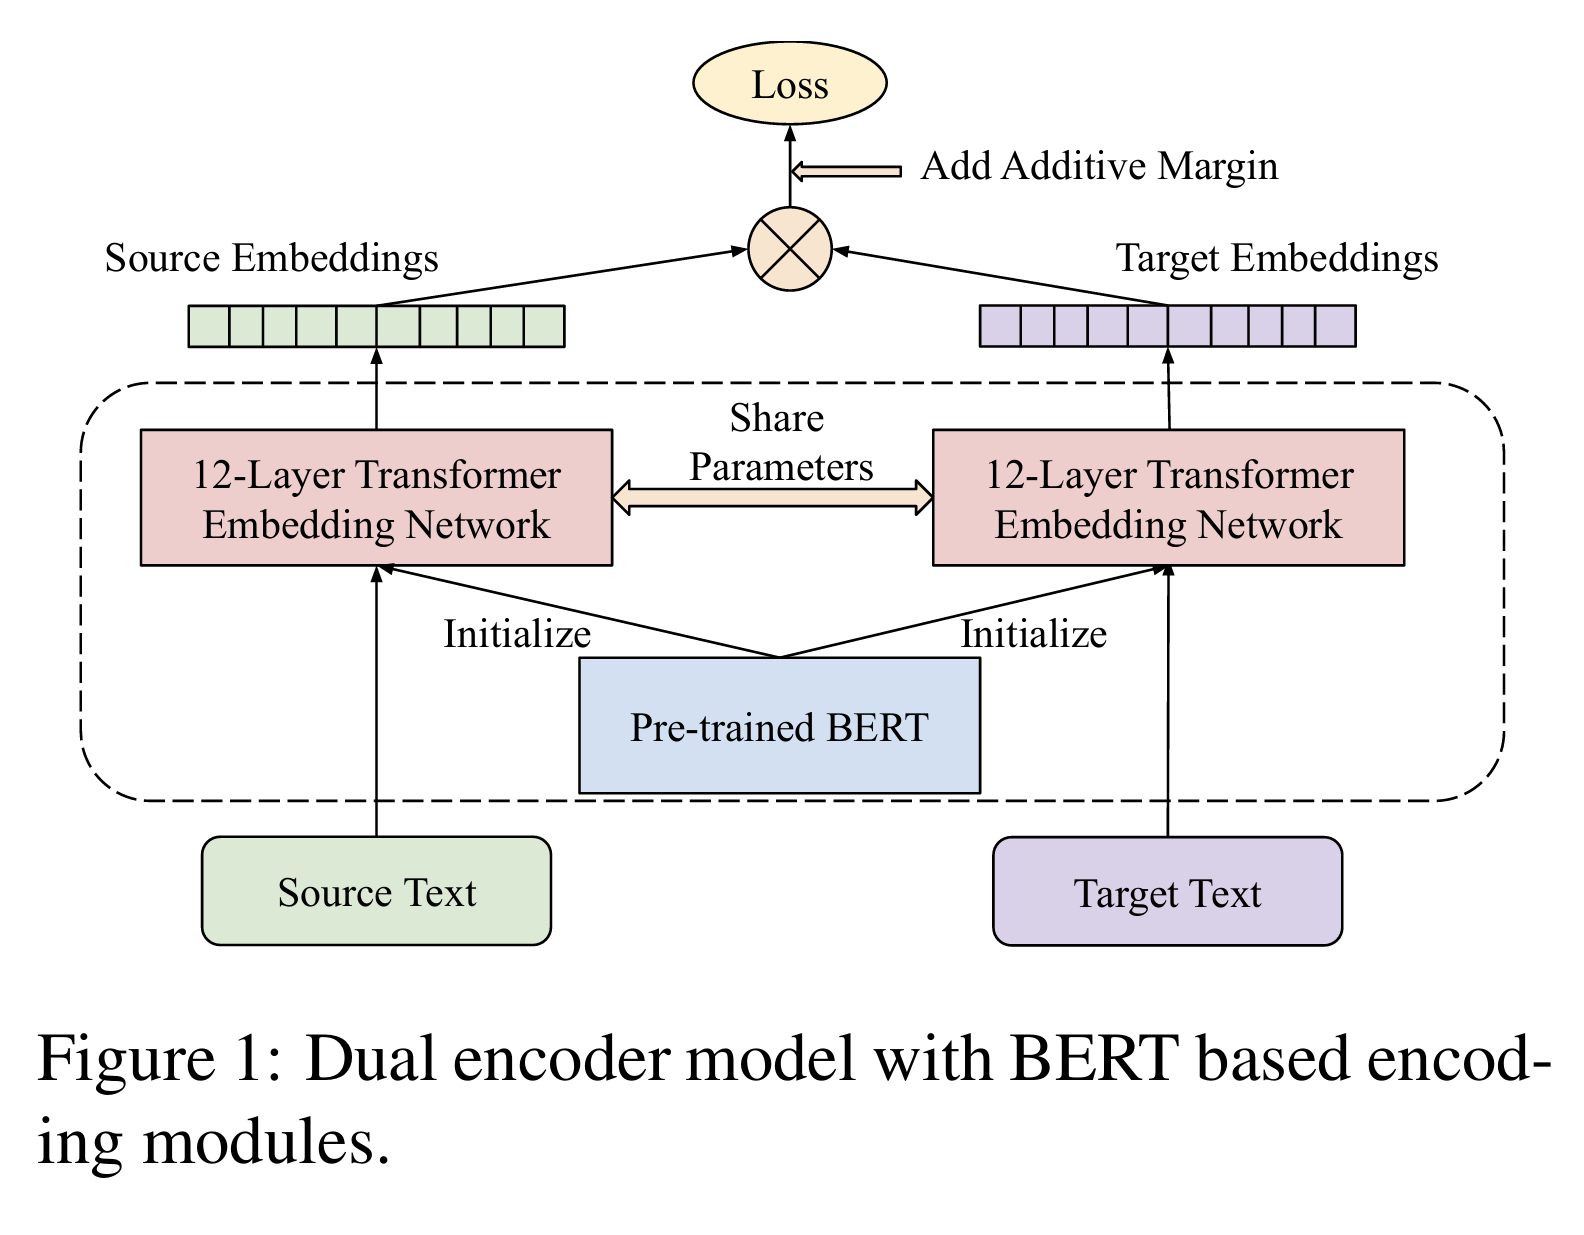

Обучение мультиязычных эмбеддингов в этом случае основано на приближении эмбеддингов одних и тех же предложений на разных языках при помощи 12-уровневой модели трансформера, формирующей эмбеддинги, с одними и теми же весами на разных языках. Проведём небольшой эксперимент и проверим, что модель действительно обладает свойством мультиязычности.

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

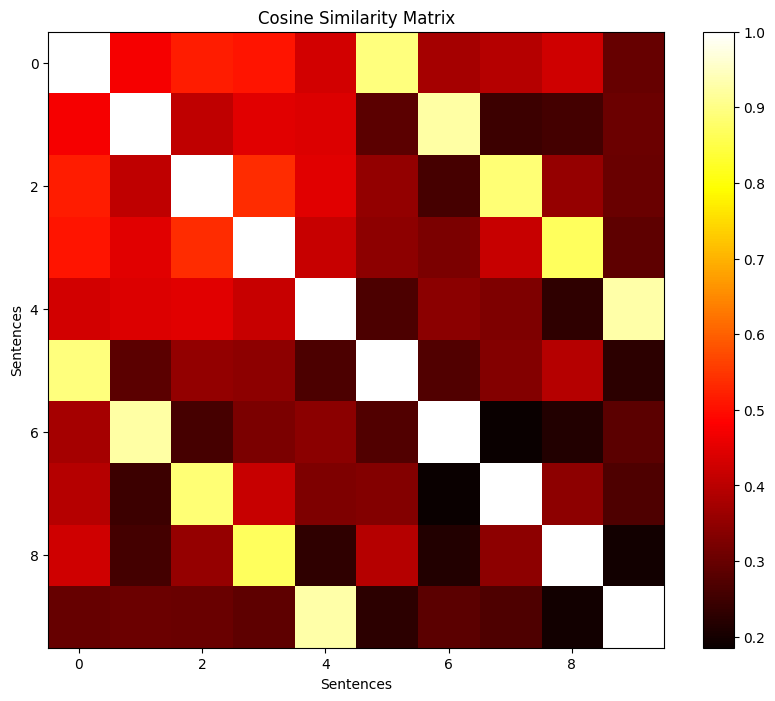

Similarity matrix:
[[1.         0.47477305 0.51932895 0.5071898  0.42779315 0.8946871
  0.37413907 0.39537576 0.42664012 0.29803833]
 [0.47477305 0.99999994 0.40762505 0.44948417 0.44242197 0.28703174
  0.92642796 0.24674857 0.25569195 0.30463782]
 [0.51932895 0.40762505 1.         0.5367869  0.44769943 0.35156953
  0.26104495 0.88760555 0.35703316 0.30249947]
 [0.5071898  0.44948417 0.5367869  1.         0.4156188  0.3463592
  0.32278374 0.4168269  0.868285   0.28749764]
 [0.42779315 0.44242197 0.44769943 0.4156188  1.0000004  0.26711768
  0.34387994 0.32551455 0.23172364 0.9286377 ]
 [0.8946871  0.28703174 0.35156953 0.3463592  0.26711768 1.
  0.27205175 0.3341481  0.39344323 0.22846603]
 [0.37413907 0.92642796 0.26104495 0.32278374 0.34387994 0.27205175
  0.9999999  0.1854922  0.21528625 0.2845943 ]
 [0.39537576 0.24674857 0.88760555 0.4168269  0.32551455 0.3341481
  0.1854922  1.0000002  0.34742987 0.27018487]
 [0.42664012 0.25569195 0.35703316 0.868285   0.23172364 0.39344323
  0.

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Загрузка модели LABSE
model = SentenceTransformer('LabSE')

# Случайные предложения на русском и английском
ru_sentences = [
    "Солнце светит ярко в ясном небе.",
    "Дети играют во дворе.",
    "Кофе очень вкусный сегодня утром.",
    "Морской воздух полезен для здоровья.",
    "Зима приносит много снега."
]

en_sentences = [
    "The sun shines brightly in the clear sky.",
    "Children play in the yard.",
    "Coffee tastes great today morning.",
    "Sea air is healthy for health.",
    "Winter brings a lot of snow."
]


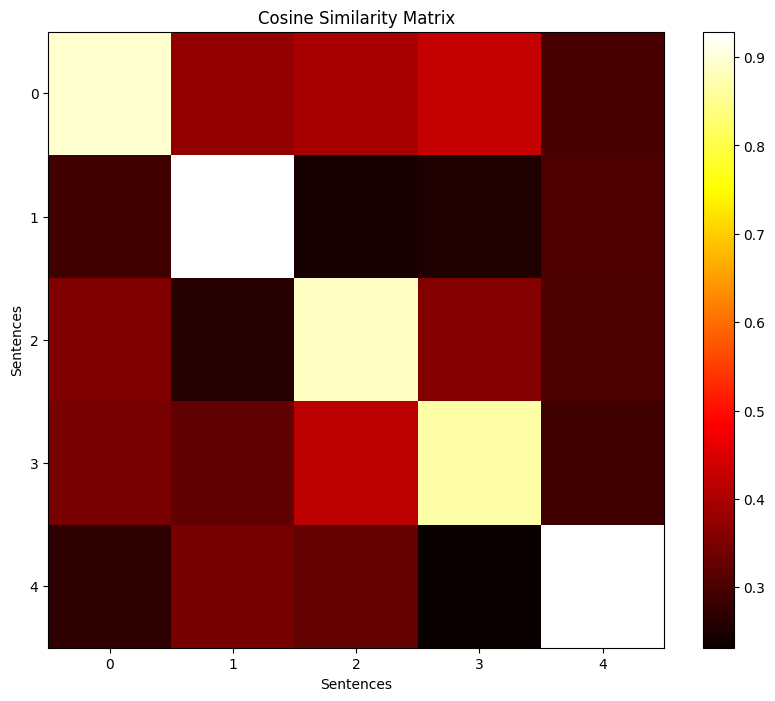

Similarity matrix:
[[0.8946872  0.37413913 0.3953758  0.42664015 0.29803836]
 [0.28703174 0.92642796 0.24674855 0.25569195 0.30463776]
 [0.35156956 0.26104498 0.8876055  0.3570332  0.30249947]
 [0.34635916 0.32278377 0.41682693 0.86828506 0.28749764]
 [0.2671177  0.34387994 0.32551455 0.23172364 0.9286376 ]]


In [ ]:


embeddings_ru = model.encode(ru_sentences)
embeddings_en = model.encode(en_sentences)

# Расчет матрицы косинусных расстояний
similarity_matrix = np.dot(embeddings_ru, embeddings_en.T)

# Визуализация матрицы
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Matrix")
plt.xlabel("Sentences")
plt.ylabel("Sentences")
plt.show()

print("Similarity matrix:")
print(similarity_matrix)

## LLM

**Большие языковые модели** (Large Language Models, LLM) - это языковые модели (обычно также построенные на базе энкодеров трансформеров), имеющие  большое количество параметров (порядок - от миллиардов до сотен миллиардов), адаптируемые для решения произвольных задач обработки естественного языка, причем сами задачи обычно также ставятся на естественном языке.

Ключевая особенность **LLM** - возможность использования для решения задач, плохо подверженных строгой формализации. Также LLM обычно хорошо справляются с задачами суммаризации, машинного перевода, извлечения именованных сущностей, ответов на вопросы по тексту.

Обычно при генерации текстов при помощи LLM технически разделяют запросы пользователя и контекст задачи (последние обычно называют **system prompt** и он регулирует контекст, стилистику и содержание ответов на запросы пользователя).

Стандартные гиперпараметры при работе с **LLM** - температура и top_p. Температура - это параметр, который определяет вариативность генерируемых токенов. Каждый следующий токен при генерации определяется случайно, исходя из распределения вероятностей по словарю следующим образом:

$$context = w_1 ... w_{n-1} → D_v$$
Где $D_v = p_1, p_2, ... p_{|V|}$. Температура - это параметр, который помогает "сгладить" распределение делением вероятностей на некоторое число $T$. Если $T$ близко к нулю, то наиболее вероятные токены получают еще большую вероятность быть сгенерированными, а менее веероятные - практически никогда не генерируются, зато если $T$ больше $1$, генерация становится более случайной.

Top_p в LLM  — это параметр, который влияет на случайность вывода.

Он устанавливает порог вероятности включения токенов в набор кандидатов, используемый моделью для генерации вывода. Низкие значения параметра приводят к более точным ответам, а высокие — к увеличению случайности и разнообразия.

Таким образом
---
- Температура в LLM — это параметр, который влияет на разнообразие и предсказуемость генерируемого текста.

- При низкой температуре (ближе к 0) модель становится более детерминированной, выбирает слова с наивысшими вероятностями и игнорирует менее вероятные варианты, делая вывод более предсказуемым.

- При высокой температуре (выше 1) модель становится более случайной, даёт шанс даже менее вероятным словам, что может приводить к более разнообразным или неожиданным результатам

- Top_p - это порог вероятности, необходимый для включения токена в набор кандидатов для генерации

Посмотрим на эти параметры на примере небольшой LLM `SmolLM-1.7B-Instruct`



In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "HuggingFaceTB/SmolLM-1.7B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

In [ ]:
messages = [{"role": "user", "content": "What is the capital of France."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
print(input_text)
inputs = tokenizer.encode(input_text, return_tensors="pt")
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>user
What is the capital of France.<|im_end|>



In [ ]:
print(tokenizer.decode(outputs[0]))

<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
The capital of France is Paris, which is located in the north-central part of the country.<|im_end|>


Сгенерируем повторно, чтобы узнать, изменится ли ответ модели

In [ ]:
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
The capital of France is Paris, which is located in the north-central part of the country.<|im_end|>


А теперь изменим температуру


In [ ]:
outputs = model.generate(inputs, max_new_tokens=50, temperature=1.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>


## RAG-системы

RAG-системы (Retrieval Augmented Generation) - одно из наиболее развитых применений больших языковых моделей на сегодняшний день. RAG-система  — это технология, сочетающая в себе поиск релевантной информации в существующих хранилищах данных и генерацию текста с помощью языковых моделей. Проще говоря, RAG-система - это система, генерирующая ответ на некоторый вопрос по тексту со ссылкой на источник в базе данных.

Общая схема работы RAG-систем следующая:

1) Весь корпус текстов, в которых планируется поиск интересующей информации, делится на **чанки**, то есть короткие фрагменты. Вопрос о том, как конкретно делить текст на чанки, не имеет единственного ответа - существуют разные алгоритмы. Можно воспринимать чанк как набор из $n$ подряд идущих предложений

2) Поданный на вход вопрос векторизуется и (обычно при помощи одного из алгоритмов семейства KNN) для него ищутся $k$ чанков-кандидатов, потенциально содержащих ответы

3) Текст этих кандидатных чанков подается на вход языковой модели для суммаризации и поиска конкретного ответа на вопрос

Напишем небольшую простую RAG-систему и попробуем сгенерировать ответы на вопросы по небольшому отрывку текста.

In [ ]:
import numpy as np
import torch

from sklearn.neighbors import NearestNeighbors

from transformers import AutoTokenizer, AutoModel, DPRContextEncoder, pipeline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

В качестве модели для векторизации базы знаний и вопроса возьмём модели Dense Passage Retrieval, специально обученные для работы с RAG-системами

In [ ]:
# Model for encoding the context
tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-ctx_encoder-multiset-base", device = device)
model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-multiset-base")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-multiset-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Model for encoding the question
q_tokenizer = AutoTokenizer.from_pretrained("facebook/dpr-question_encoder-multiset-base", device = device)
q_model = AutoModel.from_pretrained("facebook/dpr-question_encoder-multiset-base")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-multiset-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


А в качестве языковой модели для суммаризации ответов возьмём Google Flan.

In [ ]:
# Model for context question answering
pipe = pipeline("text2text-generation", model="google/flan-t5-base", device = device)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


Напишем функцию векторизации чанков

In [ ]:
def vectorize_chunks(chunks, tokenizer, model):
  tokenized = tokenizer(chunks, add_special_tokens=True, return_token_type_ids=False, padding=True)
  input_ids = torch.tensor(tokenized.input_ids)
  attention_mask = torch.tensor(tokenized.attention_mask)
  model = model.to(device)

  last_hidden_states = []
  with torch.no_grad():
    for i in tqdm(range(0, len(input_ids), 100)):
      tmp1 = input_ids[i:i+100].to(device)
      tmp2 = attention_mask[i:i+100].to(device)
      last_hidden_states.append(model(tmp1, attention_mask=tmp2).pooler_output.detach().cpu())

  features = torch.cat(last_hidden_states, dim=0)
  print(f"Done\nShape of features array: {features.shape}")

  return features

А также векторизации вопроса

In [ ]:
def vectorize_question(question, q_tokenizer, q_model):
  q_tokenized = q_tokenizer(question, add_special_tokens=True, return_token_type_ids=False)
  id = torch.tensor([q_tokenized.input_ids])
  mask = torch.tensor([q_tokenized.attention_mask])
  outp = q_model(id, attention_mask=mask).pooler_output.detach()
  return outp[0]


Также функцию для поиска ближайших чанков

In [ ]:
def find_nearest_chunks(features, question, n_neighbors=5):
  features = features.numpy()
  nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
  nn_model.fit(features)
  target_vector = question.reshape(1, -1)
  distances, indices = nn_model.kneighbors(target_vector)
  return indices[0].tolist()

И получения ответа на вопрос по найденному чанку при помощи LLM:

In [ ]:
def answer(question, chunks, features, pipe, NN, q_tokenizer, q_model):
  question_vector = vectorize_question(question, q_tokenizer, q_model)
  indices = find_nearest_chunks(features, question_vector, n_neighbors=NN)
  relevant = [chunks[i] for i in indices]
  prompt = "Source: " + " ".join(relevant[:5]) + "\n\nUsing the source answer the question: " + question
  answer = pipe(prompt)[0]["generated_text"]
  print(f"Q: {question}")
  print(f"A: {answer}")
  print()
  print("Based on:")
  for line in relevant:
    print(line)

Протестируем нашу систему: возьмем небольшой текст на английском языке - рассказ Эрнеста Хемингуэя "Индийский Лагерь"

Этот рассказ достаточно короткий и мы разделим его на чанки построчно.

In [ ]:
text = """
At the lake shore there was another rowboat drawn up. The two Indians stood waiting.

Nick and his father got in the stern of the boat and the Indians shoved it off and one of them got in to row. Uncle George sat in the stern of the camp rowboat. The young Indian shoved the camp boat off and got in to row Uncle George.

The two boats started off in the dark. Nick heard the oar-locks of the other boat quite a way ahead of them in the mist. The Indians rowed with quick choppy strokes. Nick lay back with his father's arm around him. It was cold on the water. The Indian who was rowing them was working very hard, but the other boat moved further ahead in the mist all the time.

"Where are we going, Dad?" Nick asked.

"Over to the Indian camp. There is an Indian lady very sick."

"Oh," said Nick.

Across the bay they found the other boat beached. Uncle George was smoking a cigar in the dark. The young Indian pulled the boat way up the beach. Uncle George gave both the Indians cigars.

They walked up from the beach through a meadow that was soaking wet with dew, follow虹ng the young Indian who carried a lantern. Then they went into the woods and followed a trail that led to the logging road that ran back into the hills. It was much lighter on the logging road as the timber was cut away on both sides. The young Indian stopped and blew out his lantern and they all walked on along the road.

They came around a bend and a dog came out barking. Ahead were the lights of the shanties where the Indian bark-peelers lived. More dogs rushed out at them. The two Indians sent them back to the shanties. In the shanty nearest the road there was a light in the window. An old woman stood in the doorway holding a lamp.

Inside on a wooden bunk lay a young Indian woman. She had been trying to have her baby for two days. All the old women in the camp had been helping her. The men had moved off up the road to sit in the dark and smoke out of range of the noise she made. She screamed just as Nick and the two Indians followed his father and Uncle George into the shanty. She lay in the lower bunk, very big under a quilt. Her head was turned to one side. In the upper bunk was her husband. He had cut his foot very badly with an ax three days before. He was smoking a pipe. The room smelled very bad.

Nick's father ordered some water to be put on the stove, and while it was heating he spoke to Nick.

"This lady is going to have a baby, Nick," he said.

"I know," said Nick.

"You don't know," said his father. "Listen to me. What she is going through is called being in labor. The baby wants to be born and she wants it to be born. All her muscles are trying to get the baby born. That is what is happening when she screams."

"I see," Nick said.

Just then the woman cried out.

"Oh, Daddy, can't you give her something to make her stop screaming?" asked Nick.

"No. I haven't any anæsthetic," his father said. "But her screams are not important. I don't hear them because they are not important."

The husband in the upper bunk rolled over against the wall.

The woman in the kitchen motioned to the doctor that the water was hot. Nick's father went into the kitchen and poured about half of the water out of the big kettle into a basin. Into the water left in the kettle he put several things he unwrapped from a handkerchief.

"Those must boil," he said, and began to scrub his hands in the basin of hot water with a cake of soap he had brought from the camp. Nick watched his father's hands scrubbing each other with the soap. While his father washed his hands very carefully and thoroughly, he talked.

"You see, Nick, babies are supposed to be born head first but sometimes they're not. When they're not they make a lot of trouble for every苑ody. Maybe I'll have to operate on this lady. We'll know in a little while."

When he was satisfied with his hands he went in and went to work.

"Pull back that quilt, will you, George?" he said. "I'd rather not touch it."

Later when he started to operate Uncle George and three Indian men held the woman still. She bit Uncle George on the arm and Uncle George said, "Damn squaw bitch!" and the young Indian who had rowed Uncle George over laughed at him. Nick held the basin for his father. It all took a long time.

His father picked the baby up and slapped it to make it breathe and handed it to the old woman.

"See, it's a boy, Nick," he said. "How do you like being an interne?"

Nick said, "All right." He was looking away so as not to see what his father was doing.

"There. That gets it," said his father and put something into the basin.

Nick didn't look at it.

"Now," his father said, "there's some stitches to put in. You can watch this or not, Nick, just as you like. I'm going to sew up the incision I made."

Nick did not watch. His curiosity has been gone for a long time.

His father finished and stood up. Uncle George and the three Indian men stood up. Nick put the basin out in the kitchen.

Uncle George looked at his arm. The young Indian smiled reminiscently.

"I'll put some peroxide on that, George," the doctor said.

He bent over the Indian woman. She was quiet now and her eyes were closed. She looked very pale. She did not know what had become of the baby or anything.

"I'll be back in the morning," the doctor said, standing up. "The nurse should be here from St. Ignace by noon and she'll bring everything we need."

He was feeling exalted and talkative as football players are in the dressing room after a game.

"That's one for the medical journal, George," he said. "Doing a Caesarian with a jack-knife and sewing it up with nine-foot, tapered gut leaders."

Uncle George was standing against the wall, looking at his arm.

"Oh, you're a great man, all right," he said.

"Ought to have a look at the proud father. They're usually the worst sufferers in these little affairs," the doctor said. "I must say he took it all pretty quietly."

He pulled back the blanket from the Indian's head. His hand came away wet. He mounted on the edge of the lower bunk with the lamp in one hand and looked in. The Indian lay with his face toward the wall. His throat had been cut from ear to ear. The blood had flowed down into a pool where his body sagged the bunk. His head rested on his left arm. The open razor lay, edge up, in the blankets.

"Take Nick out of the shanty, George," the doctor said.

There was no need of that. Nick, standing in the door of the kitchen, had a good view of the upper bunk when his father, the lamp in one hand, tipped the Indian's head back.

It was just beginning to be daylight when they walked along the logging road back toward the lake.

"I'm terribly sorry I brought you along, Nickie," said his father, all his post-operative exhilaration gone. "It was an awful mess to put you through."

"Do ladies always have such a hard time hav虹ng babies?" Nick asked.

"No, that was very, very exceptional."

"Why did he kill himself, Daddy?"

"I don't know, Nick. He couldn't stand things, I guess."

"Do many men kill themselves, Daddy?"

"Not very many, Nick."

"Do many women?"

"Hardly ever."

"Don't they ever?"

"Oh, yes. They do sometimes."

"Daddy?"

"Yes."

"Where did Uncle George go?"

"He'll turn up all right."

"Is dying hard, Daddy?"

"No, I think it's pretty easy, Nick. It all depends."

They were seated in the boat, Nick in the stern, his father rowing. The sun was coming up over the hills. A bass jumped, making a circle in the water. Nick trailed his hand in the water. It felt warm in the sharp chill of the morning.

In the early morning on the lake sitting in the stern of the boat with his father rowing, he felt quite sure that he would never die.
"""

In [ ]:
chunks = [line for line in text.split('\n')]
not_empty_chunks = chunks[1::2]

In [ ]:
vectorized_chunks = vectorize_chunks(not_empty_chunks, tokenizer, model)

100%|██████████| 1/1 [00:40<00:00, 40.06s/it]

Done
Shape of features array: torch.Size([65, 768])


Зададим гиперпараметры поиска и попробуем найти ответ на некоторый конкретный вопрос по тексту:

In [ ]:
NN = 3

In [ ]:
question = "How many indians stood waiting?"

answer(question, not_empty_chunks, vectorized_chunks, pipe, NN, q_tokenizer, q_model)

Q: How many indians stood waiting?
A: 2

Based on:
At the lake shore there was another rowboat drawn up. The two Indians stood waiting.
He bent over the Indian woman. She was quiet now and her eyes were closed. She looked very pale. She did not know what had become of the baby or anything.
His father finished and stood up. Uncle George and the three Indian men stood up. Nick put the basin out in the kitchen.


In [ ]:
question = "On what young Indian woman laid?"

answer(question, not_empty_chunks, vectorized_chunks, pipe, NN, q_tokenizer, q_model)

Q: On what young Indian woman laid?
A: a wooden bunk

Based on:
He bent over the Indian woman. She was quiet now and her eyes were closed. She looked very pale. She did not know what had become of the baby or anything.
Inside on a wooden bunk lay a young Indian woman. She had been trying to have her baby for two days. All the old women in the camp had been helping her. The men had moved off up the road to sit in the dark and smoke out of range of the noise she made. She screamed just as Nick and the two Indians followed his father and Uncle George into the shanty. She lay in the lower bunk, very big under a quilt. Her head was turned to one side. In the upper bunk was her husband. He had cut his foot very badly with an ax three days before. He was smoking a pipe. The room smelled very bad.
He pulled back the blanket from the Indian's head. His hand came away wet. He mounted on the edge of the lower bunk with the lamp in one hand and looked in. The Indian lay with his face toward the wa

Таким образом, мы построили эффективную систему, способную давать осмысленные аргументированные ответы на вопросы по тексту.